In [2]:
!pip install langchainhub
!pip install langchain-openai
!pip install langchain
!pip install beautifulsoup4
!pip install langchain-community
!pip install faiss-cpu
!pip install -U langchain-community tavily-python
!pip install gradio_client==0.2.10
!pip install gradio==3.38.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: gradio_client
    Found existing installation: gradio_client 1.8.0
    Uninstalling gradio_client-1.8.0:
      Successfully uninstalled gradio_client-1.8.0


In [28]:
import json

from google.colab import drive
drive.mount('/content/drive')

with open("/content/drive/MyDrive/keys.json", "r") as f:
  open_api_key = json.loads(f.read())["open_api_key"]

with open("/content/drive/MyDrive/keys.json", "r") as f:
  tavily_api_key = json.loads(f.read())["tavily_api_key"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-4o-mini", model_provider="openai", api_key=open_api_key)

# **RAG**

In [5]:
%pip install -qU langchain-community
from langchain_community.document_loaders import WebBaseLoader

url = input("Enter the URL address of the site you wish to query: ") # https://www.bestbuy.com/site/iphone/all-iphone/pcmcat1683750935583.c?id=pcmcat1683750935583
# url = "https://www.bestbuy.com/site/iphone/all-iphone/pcmcat1683750935583.c?id=pcmcat1683750935583"
loader = WebBaseLoader(url)
data = loader.load()

In [30]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(api_key=open_api_key)

In [7]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(data)
vector = FAISS.from_documents(documents, embeddings)

In [8]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(api_key=api_key)
output_parser = StrOutputParser()

prompt = ChatPromptTemplate.from_template("""Answer the following question based solely on the provided context:
<context>
{context}
</context>

Question: {input}""", output_parser=output_parser)

document_chain = create_stuff_documents_chain(llm=llm, prompt=prompt)

In [9]:
from langchain.chains import create_retrieval_chain

retriever = vector.as_retriever()
retrieval_chain = create_retrieval_chain(llm, prompt)

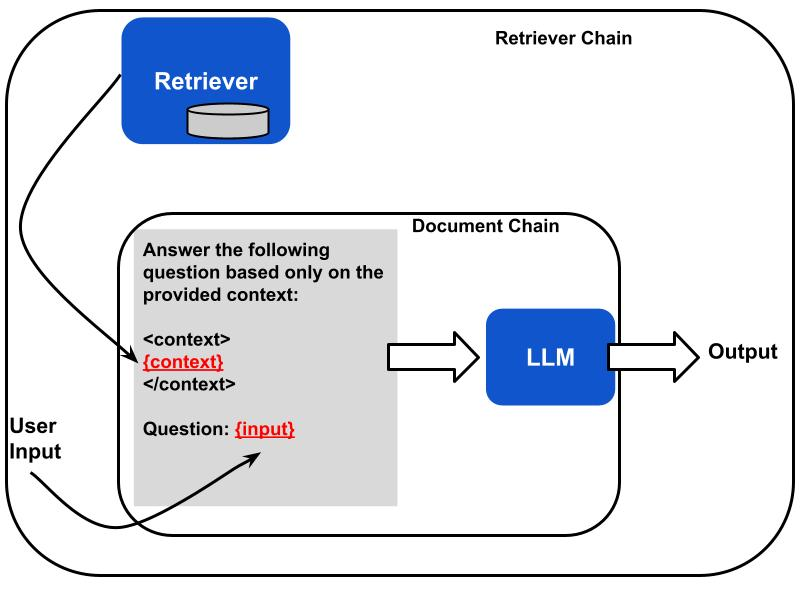

# **Agent**

In [13]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool = create_retriever_tool(
    retriever,
    "webpage_search",
    "Search for information on the webpage. For any questions about the supplied webpage, use this tool.",
)

In [32]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper(tavily_api_key=tavily_api_key)
search_tool = TavilySearchResults(api_wrapper=search)

In [33]:
tools = [retriever_tool, search_tool]

In [34]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain.agents import AgentExecutor

prompt = hub.pull("hwchase17/openai-functions-agent", api_key=open_api_key)

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, api_key=open_api_key)
agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [35]:
print(prompt)

input_variables=['agent_scratchpad', 'input'] optional_variables=['chat_history'] input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')]

In [36]:
result = agent_executor.invoke({"input": "Show me the different iPhone models"})



> Entering new AgentExecutor chain...

Invoking: `webpage_search` with `{'query': 'iPhone models'}`


skip to resultsskip to filtersBest BuyCell PhonesiPhoneAll iPhone Categories & FiltersGet it fastStore PickupSame-day pickupModel FamilyApple iPhone 15Apple iPhone 15 PlusApple iPhone 15 ProApple iPhone 15 Pro MaxApple iPhone 14Apple iPhone 14 Pro MaxApple iPhone 14 ProApple iPhone 14 PlusApple iPhone 11Apple iPhone 12Show MoreConditionNewPre-OwnedRefurbishedOpen-BoxCarrier CompatibilityUnlockedT-MobileAT&TVerizonMetro by T-MobileMint MobileCricketVisibleShow MoreBrandBest Buy BrandsAppleInsignia™ZAGGInternal Storage Capacity1000 gigabytes512 gigabytes256 gigabytes128 gigabytes64 gigabytesPricetoLess than $25$25 - $49.99$75 - $99.99$100 - $149.99$150 - $199.99$200 - $249.99$250 - $499.99$500 - $749.99$750 - $999.99$1000 - $1249.99Current DealsOn SaleFree Shipping EligiblePackage DealsNo Contract/UnlockedUnlockedNo-ContractColorPinkWhiteBlackGrayBluePurpleSpace GrayGreenShow MoreFeatu

In [38]:
print(result["output"])

Here are some of the iPhone models available:

1. Apple iPhone 15
2. Apple iPhone 15 Plus
3. Apple iPhone 15 Pro
4. Apple iPhone 15 Pro Max
5. Apple iPhone 14
6. Apple iPhone 14 Pro Max
7. Apple iPhone 14 Pro
8. Apple iPhone 14 Plus
9. Apple iPhone 11
10. Apple iPhone 12

These are some of the iPhone models currently available in the market.


# **Gradio - To quickly build and share ML apps**

In [39]:
import gradio as gr

In [40]:
def predict(message, _):
  result = agent_executor.invoke({"input": message})
  return result["output"]

In [43]:
gr.ChatInterface(predict,
    chatbot=gr.Chatbot(height=300),
    textbox=gr.Textbox(placeholder="Hi I am your virtual assistant, how can I help you today?", container=False, scale=7),
    title="BotAssist",
    theme="soft",
    examples=["What is the weather like in SF?", "What is LangSmith?"],
    retry_btn=None,
    undo_btn="Delete Previous",
    clear_btn="Clear",).launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
IMPORTANT: You are using gradio version 3.38.0, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://8e1cd4b21721d9eaa2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
